In [1]:
import operator
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import gridspec
from matplotlib import pyplot as plt
from astropy import units as u
from astropy.table import QTable
from astropy.coordinates import angular_separation
from magicctapipe.utils import (
    check_tel_combination,
    get_dl2_mean,
)
from pyirf.cuts import (
    calculate_percentile_cut,
    evaluate_binned_cut,
)
from pyirf.irf import effective_area_per_energy
from pyirf.simulations import SimulatedEventsInfo
from ctaplot.ana import (
    logbin_mean,
    energy_bias,
    energy_resolution_per_energy,
    angular_resolution_per_energy,
)

In [2]:
# Display all columns:
pd.set_option('display.max_columns', None)

# Configure the default pyplot figure:
plt.rcParams.update({
    'figure.figsize': (12, 9),
    'font.size': 15,
    'grid.linestyle': 'dotted',
})

In [3]:
def calc_reldiff_err(x, y, xerr, yerr):
    """
    Calculates the error of relative differences, i.e., the error of f = (x - y) / y
    """
    
    return np.sqrt((xerr/y) ** 2 + (x*yerr/(y**2)) ** 2)

# Load MAGIC DL2 test MC

### Load an input file and apply quality cuts:

In [4]:
# === Settings ===
path_magic = '/fefs/aswg/workspace/yoshiki.ohtani/analysis/combined_analysis/mc/zd40deg_az90deg/4.dl1_to_dl2/' \
             'data_magic/gamma_off0.4deg/dl2/merged/dl2_gamma_40deg_90deg_off0.4deg_LST-1_MAGIC_run401_to_1000.h5'

# quality_cuts = 'intensity_width_2 < 0.2'

# === Main ===
print('Loading the following file:')
print(Path(path_magic).name)

data_magic = pd.read_hdf(path_magic, 'events/parameters')
data_magic.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
data_magic.sort_index(inplace=True)

_ = check_tel_combination(data_magic)

# print('Applying the quality cuts:')
# print(quality_cuts)

# data_magic.query(quality_cuts, inplace=True)
# data_magic['multiplicity'] = data_magic.groupby(['obs_id', 'event_id']).size()
# data_magic.query('multiplicity > 1', inplace=True)

# combo_types = check_tel_combination(data_magic)
# data_magic.update(combo_types)

Loading the following file:
dl2_gamma_40deg_90deg_off0.4deg_LST-1_MAGIC_run401_to_1000.h5



In total 542907 stereo events are found:
m1_m2 (type 0): 542907 events (100.0%)
lst1_m1 (type 1): 0 events (0.0%)
lst1_m2 (type 2): 0 events (0.0%)
lst1_m1_m2 (type 3): 0 events (0.0%)


In [5]:
data_magic.head()

pointing_alt  pointing_az  true_energy  true_alt  \
obs_id event_id tel_id                                                     
401    13603    2           0.865683     1.570796     0.623625      50.0   
                3           0.865683     1.570796     0.623625      50.0   
       13605    2           0.865683     1.570796     0.623625      50.0   
                3           0.865683     1.570796     0.623625      50.0   
       13606    2           0.865683     1.570796     0.623625      50.0   

                          true_az  true_disp  true_core_x  true_core_y  \
obs_id event_id tel_id                                                   
401    13603    2       89.999996   0.271559   -13.296012   -13.278467   
                3       89.999996   0.143503   -13.296012   -13.278467   
       13605    2       89.999996   0.871795  -153.317642  -135.251175   
                3       89.999996   0.697496  -153.317642  -135.251175   
       13606    2       89.999996   0.467384   -43.840717     8.326108   

                        true_impact  n_pixels  n_islands  magic_stereo  \
obs_id event_id tel_id                                                   
401    13603    2         53.781362        25          1          True   
                3         31.802946        25          1          True   
       13605    2        209.426836        15          1          True   
                3        171.002237        30          1          True   
       13606    2         87.658801        29          1          True   

                         intensity  skewness  kurtosis         x         y  \
obs_id event_id tel_id                                                       
401    13603    2       361.691213 -0.105109  3.240736  0.146110  0.075534   
                3       343.057076 -0.168967  2.609355  0.086487 -0.027991   
       13605    2       152.075211 -0.146876  2.127085  0.028732  0.242115   
                3       529.603398 -0.896360  3.308850 -0.017304  0.155700   
       13606    2       396.464334  0.440234  2.266879  0.169033  0.128870   

                               r        phi    length  length_uncertainty  \
obs_id event_id tel_id                                                      
401    13603    2       0.164480  27.337523  0.038841            0.001529   
                3       0.090904 -17.933980  0.035061            0.001201   
       13605    2       0.243814  83.232348  0.039845            0.001715   
                3       0.156658  96.341632  0.059166            0.001953   
       13606    2       0.212556  37.321774  0.045105            0.001275   

                           width  width_uncertainty        psi  intercept  \
obs_id event_id tel_id                                                      
401    13603    2       0.027924           0.001028   2.986770   9.102135   
                3       0.028015           0.000971  22.777923  10.210404   
       13605    2       0.018385           0.000774 -58.240280   8.804272   
                3       0.019397           0.000655 -49.603113   9.473720   
       13606    2       0.029396           0.001170  45.085276   9.680475   

                        deviation      slope  pixels_width_1  pixels_width_2  \
obs_id event_id tel_id                                                         
401    13603    2        0.549673  -0.704183             0.0             0.0   
                3        0.964179  15.627531             0.0             0.0   
       13605    2        0.470323  -5.870538             0.0             0.0   
                3        0.755000   0.110890             0.0             0.0   
       13606    2        0.688451 -10.537660             0.0             0.0   

                        intensity_width_1  intensity_width_2  multiplicity  \
obs_id event_id tel_id                                                       
401    13603    2                     0.0                0.0             2   
                3              

### Compute the mean of the DL2 parameters:

In [6]:
print('Computing the mean of the DL2 parameters...')
dl2_magic = get_dl2_mean(data_magic)

theta = angular_separation(
    lon1=u.Quantity(dl2_magic['true_az'].to_numpy(), u.deg),
    lat1=u.Quantity(dl2_magic['true_alt'].to_numpy(), u.deg),
    lon2=u.Quantity(dl2_magic['reco_az'].to_numpy(), u.deg),
    lat2=u.Quantity(dl2_magic['reco_alt'].to_numpy(), u.deg),
)

dl2_magic['theta2'] = theta.to(u.deg).value ** 2

Computing the mean of the DL2 parameters...


In [7]:
dl2_magic.head()

combo_type  gammaness  reco_energy   reco_alt    reco_az  \
obs_id event_id                                                             
401    13603            0.0   0.916000     0.504931  50.271352  90.200619   
       13605            0.0   0.952833     0.323265  50.041818  90.195792   
       13606            0.0   0.920250     0.486283  49.819992  90.169525   
       13609            0.0   0.985833     0.598616  49.977630  90.058838   
       15600            0.0   0.971333     0.210772  49.983228  90.112785   

                 pointing_alt  pointing_az  true_energy  true_alt    true_az  \
obs_id event_id                                                                
401    13603         0.865683     1.570796     0.623625      50.0  89.999996   
       13605         0.865683     1.570796     0.623625      50.0  89.999996   
       13606         0.865683     1.570796     0.623625      50.0  89.999996   
       13609         0.865683     1.570796     0.623625      50.0  89.999996   
       15600         0.865683     1.570796     0.216644      50.0  89.999996   

                   theta2  
obs_id event_id            
401    13603     0.090168  
       13605     0.017575  
       13606     0.044322  
       13609     0.001932  
       15600     0.005539

# Load LST-1 + MAGIC DL2 test MC

### Load an input file and apply quality cuts:

In [8]:
# === Settings ===
path_mlst = '/fefs/aswg/workspace/yoshiki.ohtani/analysis/combined_analysis/mc/zd40deg_az90deg/4.dl1_to_dl2/' \
            'data/gamma_off0.4deg/dl2/merged/dl2_gamma_40deg_90deg_off0.4deg_LST-1_MAGIC_run401_to_1000.h5'

# quality_cuts = 'intensity_width_2 < 0.2'

# === Main ===
print('Loading the following file:')
print(Path(path_mlst).name)

data_mlst = pd.read_hdf(path_mlst, 'events/parameters')
data_mlst.set_index(['obs_id', 'event_id', 'tel_id'], inplace=True)
data_mlst.sort_index(inplace=True)

_ = check_tel_combination(data_mlst)

# print('Applying the quality cuts:')
# print(quality_cuts)

# data_mlst.query(quality_cuts, inplace=True)
# data_mlst['multiplicity'] = data_mlst.groupby(['obs_id', 'event_id']).size()
# data_mlst.query('multiplicity > 1', inplace=True)

# combo_types = check_tel_combination(data_mlst)
# data_mlst.update(combo_types)

Loading the following file:
dl2_gamma_40deg_90deg_off0.4deg_LST-1_MAGIC_run401_to_1000.h5



In total 967658 stereo events are found:
m1_m2 (type 0): 2317 events (0.2%)
lst1_m1 (type 1): 154371 events (16.0%)
lst1_m2 (type 2): 270380 events (27.9%)
lst1_m1_m2 (type 3): 540590 events (55.9%)


In [9]:
data_mlst.head()

pointing_alt  pointing_az  true_energy  true_alt  \
obs_id event_id tel_id                                                     
401    801      1           0.865683     1.570796     0.140737      50.0   
                2           0.865683     1.570796     0.140737      50.0   
       909      1           0.865683     1.570796     0.301781      50.0   
                3           0.865683     1.570796     0.301781      50.0   
       3600     1           0.865683     1.570796     0.144728      50.0   

                          true_az  true_disp  true_core_x  true_core_y  \
obs_id event_id tel_id                                                   
401    801      1       89.999996   0.374802   -66.894005    77.399010   
                2       89.999996   0.527436   -66.894005    77.399010   
       909      1       89.999996   0.710583    38.867409   284.020111   
                3       89.999996   1.034096    38.867409   284.020111   
       3600     1       89.999996   0.436718   -80.773026   162.182770   

                        true_impact  n_pixels  n_islands  magic_stereo  \
obs_id event_id tel_id                                                   
401    801      1         64.888548        24          1          True   
                2        133.373130        13          1          True   
       909      1        139.017902        27          1         False   
                3        213.306102        16          1         False   
       3600     1         81.793319        22          1         False   

                         intensity  skewness  kurtosis         x         y  \
obs_id event_id tel_id                                                       
401    801      1       334.670504 -0.343692  2.307648  0.121195  0.167424   
                2        83.743346  0.396146  2.287309  0.217718  0.120645   
       909      1       915.744624  0.288124  2.708427  0.523693 -0.113419   
                3       152.208123 -0.304189  2.077940  0.409414 -0.095728   
       3600     1       269.086090  0.645116  2.835470  0.316577  0.175741   

                               r        phi    length  length_uncertainty  \
obs_id event_id tel_id                                                      
401    801      1       0.206686  54.100067  0.085359            0.002668   
                2       0.248911  28.992405  0.037036            0.002296   
       909      1       0.535834 -12.220141  0.082454            0.001781   
                3       0.420457 -13.160364  0.049624            0.002088   
       3600     1       0.362086  29.035908  0.063218            0.002611   

                           width  width_uncertainty        psi  intercept  \
obs_id event_id tel_id                                                      
401    801      1       0.044844           0.001649 -56.989771  13.292052   
                2       0.021452           0.001307  47.624256   8.536034   
       909      1       0.030864           0.000753 -19.872597  14.010898   
                3       0.016815           0.000911 -15.349953   8.224294   
       3600     1       0.046211           0.002021  39.494697  12.687470   

                        deviation     slope  pixels_width_1  pixels_width_2  \
obs_id event_id tel_id                                                        
401    801      1        0.862620  6.932786        0.000000         0.00000   
                2        0.234822 -0.716290        0.000000         0.00000   
       909      1        0.663432 -2.474825        0.000000         0.00000   
                3        0.398948  6.966953        0.001925         0.00385   
       3600     1        2.930561 -3.272539        0.000000         0.00000   

                        intensity_width_1  intensity_width_2  multiplicity  \
obs_id event_id tel_id                                                       
401    801      1                0.000000           0.000000             2   
                2                0.000

### Compute the mean of the DL2 parameters:

In [10]:
print('Computing the mean of the DL2 parameters...')
dl2_mlst = get_dl2_mean(data_mlst)

theta = angular_separation(
    lon1=u.Quantity(dl2_mlst['true_az'].to_numpy(), u.deg),
    lat1=u.Quantity(dl2_mlst['true_alt'].to_numpy(), u.deg),
    lon2=u.Quantity(dl2_mlst['reco_az'].to_numpy(), u.deg),
    lat2=u.Quantity(dl2_mlst['reco_alt'].to_numpy(), u.deg),
)

dl2_mlst['theta2'] = theta.to(u.deg).value ** 2

print('\nExtracting only 3-tels events...')
dl2_mlst.query('combo_type == 3', inplace=True)

print(f'--> Number of events: {len(dl2_mlst)}')

Computing the mean of the DL2 parameters...

Extracting only 3-tels events...
--> Number of events: 540590


In [11]:
dl2_mlst.head()

combo_type  gammaness  reco_energy   reco_alt    reco_az  \
obs_id event_id                                                             
401    13603            3.0   0.963056     0.462837  50.234955  90.165366   
       13605            3.0   0.977333     0.444506  49.992795  90.133537   
       13606            3.0   0.936976     0.527422  49.942016  90.094257   
       13609            3.0   0.968333     0.595728  49.961033  90.021829   
       15600            3.0   0.972667     0.225596  49.972739  90.070327   

                 pointing_alt  pointing_az  true_energy  true_alt    true_az  \
obs_id event_id                                                                
401    13603         0.865683     1.570796     0.623625      50.0  89.999996   
       13605         0.865683     1.570796     0.623625      50.0  89.999996   
       13606         0.865683     1.570796     0.623625      50.0  89.999996   
       13609         0.865683     1.570796     0.623625      50.0  89.999996   
       15600         0.865683     1.570796     0.216644      50.0  89.999996   

                   theta2  
obs_id event_id            
401    13603     0.066448  
       13605     0.007421  
       13606     0.007038  
       13609     0.001716  
       15600     0.002788

# Check the reconstructed energy

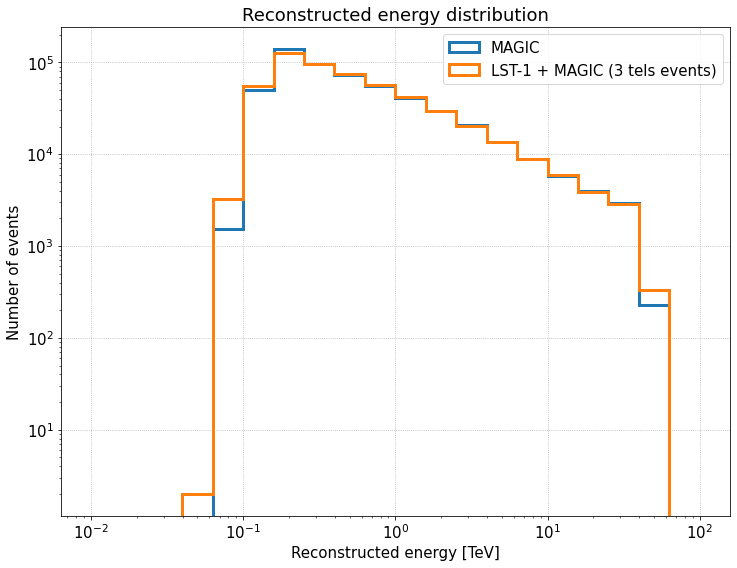

In [12]:
# === Settings ===
bins_eng = np.logspace(-2, 2, 21)

# === Main ===
plt.figure()
plt.title('Reconstructed energy distribution')
plt.xlabel('Reconstructed energy [TeV]')
plt.ylabel('Number of events')
plt.loglog()

plt.hist(
    dl2_magic['reco_energy'].to_numpy(), bins=bins_eng,
    label='MAGIC', histtype='step', linewidth=3,
)

plt.hist(
    dl2_mlst['reco_energy'].to_numpy(), bins=bins_eng,
    label='LST-1 + MAGIC (3 tels events)', histtype='step', linewidth=3,
)

plt.grid()
plt.legend()
plt.show()

# Check the gammaness

### Gammaness distribution:

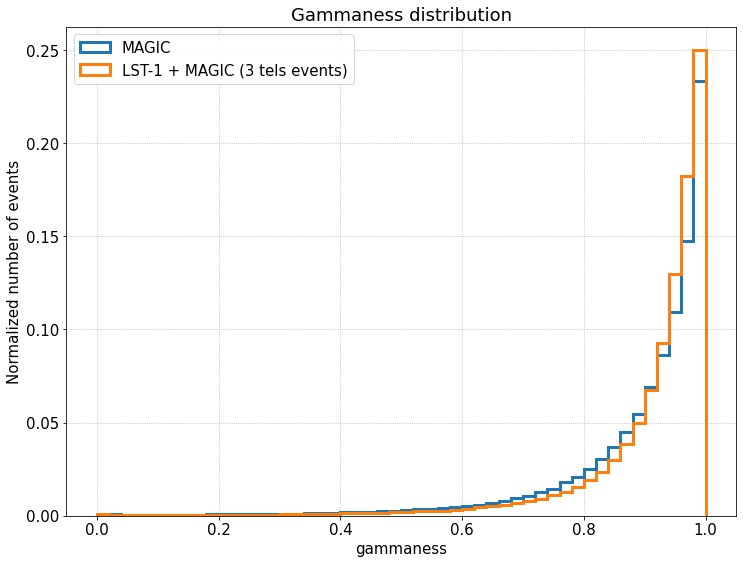

In [13]:
# === Settings ===
bins_gam = np.linspace(0, 1, 51)
yscale = 'linear'

# === Main ===
plt.figure()
plt.title('Gammaness distribution')
plt.xlabel('gammaness')
plt.ylabel('Normalized number of events')
plt.yscale(yscale)

plt.hist(
    dl2_magic['gammaness'].to_numpy(), bins=bins_gam, 
    weights=np.repeat(1/len(dl2_magic), len(dl2_magic)),
    label='MAGIC', histtype='step', linewidth=3,
)

plt.hist(
    dl2_mlst['gammaness'].to_numpy(), bins=bins_gam, 
    weights=np.repeat(1/len(dl2_mlst), len(dl2_mlst)),
    label='LST-1 + MAGIC (3 tels events)', 
    histtype='step', linewidth=3,
)

plt.grid()
plt.legend(loc='upper left')
plt.show()

### Gammaness distribution in each energy bin:

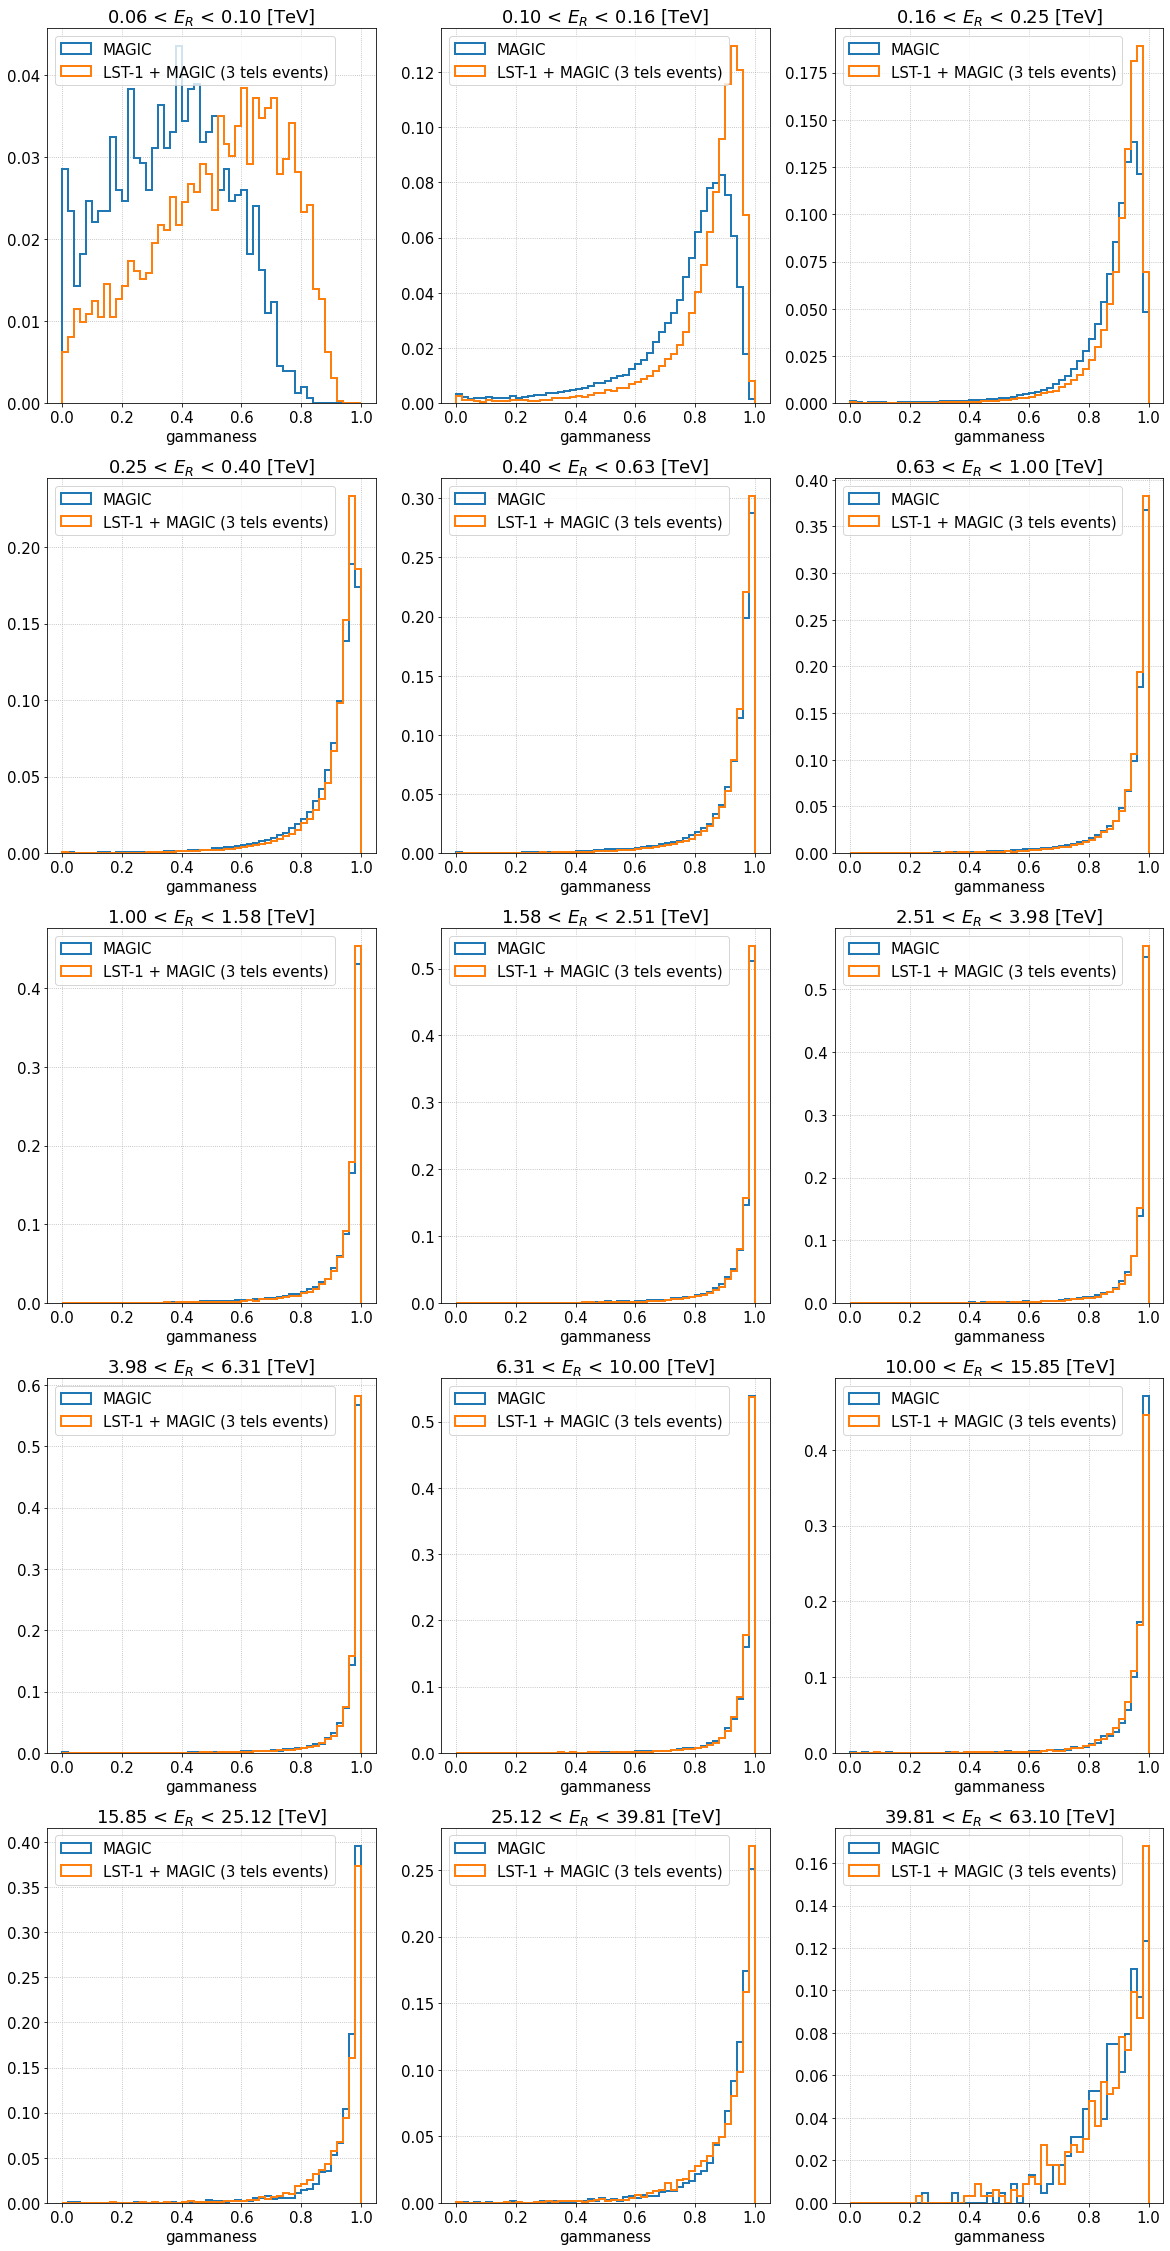

In [14]:
# === Settings ===
bins_eng = np.logspace(-2, 2, 21)[4:-1]
bins_gam = np.linspace(0, 1, 51)

figsize = (20, 40)
yscale = 'linear'

# === Main ===
plt.figure(figsize=figsize)

grid = (int(np.ceil(len(bins_eng[:-1])/3)), 3)
locs = list(itertools.product(range(grid[0]), range(grid[1])))

for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(bins_eng[:-1], bins_eng[1:])):
    
    event_cuts = f'(reco_energy > {eng_lolim}) & (reco_energy < {eng_uplim})'
    
    df_magic = dl2_magic.query(event_cuts)
    df_mlst = dl2_mlst.query(event_cuts)
    
    plt.subplot2grid(grid, locs[i_bin])
    plt.title(rf'{eng_lolim:.2f} < $E_R$ < {eng_uplim:.2f} [TeV]')
    plt.xlabel('gammaness')
    plt.yscale(yscale)

    if len(df_magic) > 0:
        plt.hist(
            df_magic['gammaness'].to_numpy(), bins=bins_gam,
            weights=np.repeat(1/len(df_magic), len(df_magic)),
            label='MAGIC', histtype='step', linewidth=2,
        )

    if len(df_mlst) > 0:
        plt.hist(
            df_mlst['gammaness'].to_numpy(), bins=bins_gam,
            weights=np.repeat(1/len(df_mlst), len(df_mlst)),
            label='LST-1 + MAGIC (3 tels events)', 
            histtype='step', linewidth=2,
        )

    plt.grid()
    plt.legend(loc='upper left')
    
plt.show()

### Gammaness cuts based on the gamma efficiency:

In [15]:
# === Settings ===
gamma_eff = 0.95
bins_eng = np.logspace(-2, 2, 21)

# === Main ===
percentile = 100 * (1 - gamma_eff)

cut_table_magic = calculate_percentile_cut(
    values=dl2_magic['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_magic['reco_energy'].to_numpy(), u.TeV),
    bins=u.Quantity(bins_eng, u.TeV),
    fill_value=1.0,
    percentile=percentile,
)

cut_table_mlst = calculate_percentile_cut(
    values=dl2_mlst['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_mlst['reco_energy'].to_numpy(), u.TeV),
    bins=u.Quantity(bins_eng, u.TeV),
    fill_value=1.0,
    percentile=percentile,
)

In [16]:
cut_table_mlst

low,high,center,cut
TeV,TeV,TeV,
float64,float64,float64,float64
0.01,0.015848931924611134,0.012924465962305568,1.0
0.015848931924611134,0.025118864315095794,0.020483898119853464,1.0
0.025118864315095794,0.039810717055349734,0.03246479068522276,1.0
0.039810717055349734,0.06309573444801933,0.05145322575168453,1.0
0.06309573444801933,0.1,0.08154786722400967,0.10474722222222226
0.1,0.15848931924611143,0.1292446596230557,0.5370666666666671
0.15848931924611143,0.25118864315095807,0.20483898119853475,0.6987142857142858
0.25118864315095807,0.3981071705534973,0.32464790685222766,0.6823369047619048


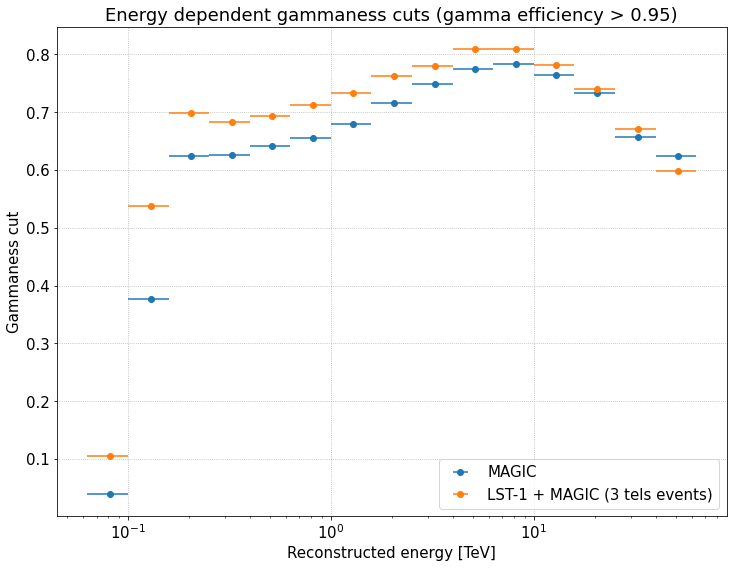

In [17]:
plt.figure()
plt.title(f'Energy dependent gammaness cuts (gamma efficiency > {gamma_eff})')
plt.xlabel('Reconstructed energy [TeV]')
plt.ylabel('Gammaness cut')
plt.semilogx()

# Mask the cut = 1:
mask = (cut_table_magic['cut'] < 1)

plt.errorbar(
    x=cut_table_magic['center'].value[mask], y=cut_table_magic['cut'].value[mask],
    xerr=[(cut_table_magic['center'] - cut_table_magic['low']).value[mask],
          (cut_table_magic['high'] - cut_table_magic['center']).value[mask]],
    label='MAGIC', fmt='o',
)

plt.errorbar(
    x=cut_table_mlst['center'].value[mask], y=cut_table_mlst['cut'].value[mask],
    xerr=[(cut_table_mlst['center'] - cut_table_mlst['low']).value[mask],
          (cut_table_mlst['high'] - cut_table_mlst['center']).value[mask]],
    label='LST-1 + MAGIC (3 tels events)', fmt='o',
)

plt.grid()
plt.legend(loc='lower right')
plt.show()

In [18]:
mask_gh_magic = evaluate_binned_cut(
    values=dl2_magic['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_magic['reco_energy'].to_numpy(), u.TeV),
    cut_table=cut_table_magic,
    op=operator.ge,
)

n_events_magic = np.count_nonzero(mask_gh_magic)
print(f'Number of survived MAGIC events: {n_events_magic}')

mask_gh_mlst = evaluate_binned_cut(
    values=dl2_mlst['gammaness'].to_numpy(),
    bin_values=u.Quantity(dl2_mlst['reco_energy'].to_numpy(), u.TeV),
    cut_table=cut_table_mlst,
    op=operator.ge,
)

n_events = np.count_nonzero(mask_gh_mlst)
print(f'Number of survived LST-1 + MAGIC events: {n_events}')

Number of survived MAGIC events: 515756
Number of survived LST-1 + MAGIC events: 513553


# Check the effective area

In [19]:
# Get the number of simulation runs:
n_runs = len(np.unique(dl2_mlst.index.get_level_values('obs_id')))

# Set the simulation info:
sim_config = pd.read_hdf(path_mlst, 'simulation/config')
n_total_showers = n_runs * sim_config['num_showers'].iloc[0] * sim_config['shower_reuse'].iloc[0]

sim_info = SimulatedEventsInfo(
    n_showers=n_total_showers,
    energy_min=u.Quantity(sim_config['energy_range_min'].iloc[0], u.TeV),
    energy_max=u.Quantity(sim_config['energy_range_max'].iloc[0], u.TeV),
    max_impact=u.Quantity(sim_config['max_scatter_range'].iloc[0], u.m),
    spectral_index=sim_config['spectral_index'].iloc[0],
    viewcone=u.Quantity(sim_config['max_viewcone_radius'].iloc[0], u.deg),
)

In [20]:
sim_info

SimulatedEventsInfo(n_showers=120000000, energy_min=0.005 TeV, energy_max=50.00 TeV, spectral_index=-2.0, max_impact=600.00 m, viewcone=0.0 deg)

In [21]:
# === Settings ===
bins_eng = np.logspace(-2, 2, 21)[2:-1]

# === Main ===
qtable_magic = QTable.from_pandas(dl2_magic)[['true_energy']]
qtable_magic['true_energy'] *= u.TeV

aeff_magic = effective_area_per_energy(
    selected_events=qtable_magic,
    simulation_info=sim_info,
    true_energy_bins=u.Quantity(bins_eng, u.TeV),
)

qtable_mlst = QTable.from_pandas(dl2_mlst)[['true_energy']]
qtable_mlst['true_energy'] *= u.TeV

aeff_mlst = effective_area_per_energy(
    selected_events=qtable_mlst,
    simulation_info=sim_info,
    true_energy_bins=u.Quantity(bins_eng, u.TeV),
)

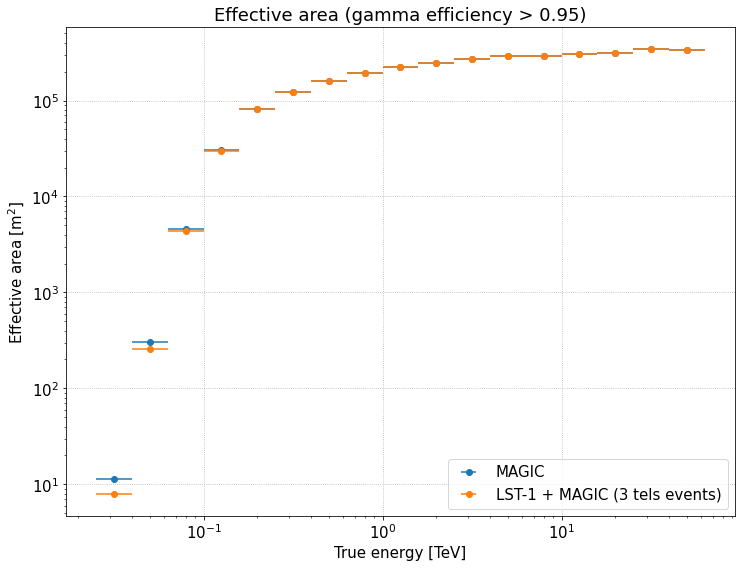

In [22]:
ebins_mean = logbin_mean(bins_eng)
ebins_lo = bins_eng[:-1]
ebins_hi = bins_eng[1:]

plt.figure()
plt.title(f'Effective area (gamma efficiency > {gamma_eff})')
plt.xlabel('True energy [TeV]')
plt.ylabel('Effective area [m$^2$]')
plt.loglog()

plt.errorbar(
    x=ebins_mean, y=aeff_magic.value,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    fmt='o', label='MAGIC',
)

plt.errorbar(
    x=ebins_mean, y=aeff_mlst.value,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    fmt='o', label='LST-1 + MAGIC (3 tels events)',
)

plt.grid()
plt.legend()
plt.show()

# Check the energy resolution

In [23]:
ebins, eres_magic = energy_resolution_per_energy(
    true_energy=dl2_magic['true_energy'][mask_gh_magic].to_numpy(),
    reco_energy=dl2_magic['reco_energy'][mask_gh_magic].to_numpy(),
)


_, eres_mlst = energy_resolution_per_energy(
    true_energy=dl2_mlst['true_energy'][mask_gh_mlst].to_numpy(),
    reco_energy=dl2_mlst['reco_energy'][mask_gh_mlst].to_numpy(),
)

# Mask the resolution = 0:
mask = (eres_magic[:, 0] > 0)

eres_magic = eres_magic[mask]
eres_mlst = eres_mlst[mask]

ebins_lo = ebins[:-1][mask]
ebins_hi = ebins[1:][mask]
ebins_mean = logbin_mean(ebins)[mask]

In [24]:
eres_mlst

array([[0.3342978 , 0.32145118, 0.34340062],
       [0.25595449, 0.25393438, 0.25811429],
       [0.19719021, 0.19622262, 0.19811763],
       [0.16703823, 0.16611289, 0.16797155],
       [0.14385481, 0.14297685, 0.14485046],
       [0.12595313, 0.12503249, 0.12676909],
       [0.10965588, 0.10876128, 0.1105653 ],
       [0.09955796, 0.09861405, 0.10044231],
       [0.09523559, 0.09401166, 0.09639325],
       [0.09454706, 0.09327948, 0.09574846],
       [0.09411064, 0.09238396, 0.09584662],
       [0.10027019, 0.09809064, 0.10260704],
       [0.11473299, 0.11130578, 0.1181498 ],
       [0.12256823, 0.11806895, 0.12770427],
       [0.1172531 , 0.10979092, 0.12263216]])

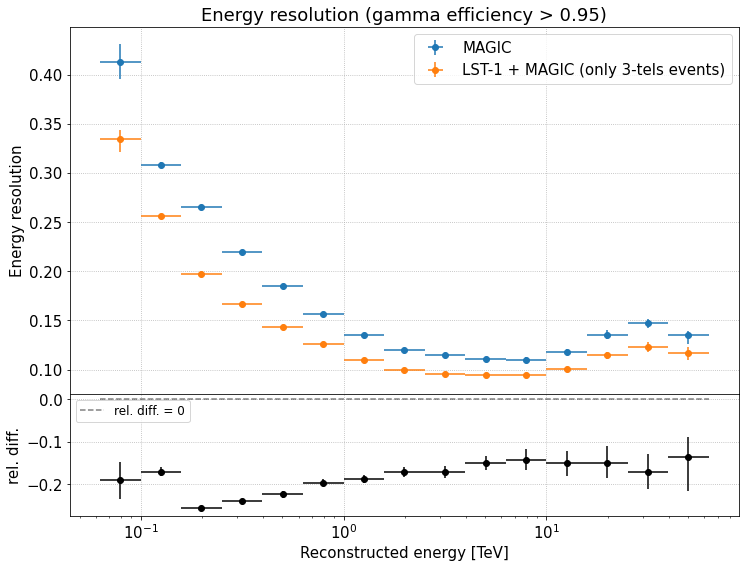

In [25]:
plt.figure()
gs = gridspec.GridSpec(4, 1)

# Plot the energy resolutions:
ax1 = plt.subplot(gs[:3])
ax1.set_title(f'Energy resolution (gamma efficiency > {gamma_eff})')
ax1.set_ylabel('Energy resolution')
ax1.semilogx()

ax1.errorbar(
    x=ebins_mean, y=eres_magic[:, 0],
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[eres_magic[:, 0] - eres_magic[:, 1], eres_magic[:, 2] - eres_magic[:, 0]],
    label='MAGIC', fmt='o', 
)

ax1.errorbar(
    x=ebins_mean, y=eres_mlst[:, 0],
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[eres_mlst[:, 0] - eres_mlst[:, 1], eres_mlst[:, 2] - eres_mlst[:, 0]],
    label='LST-1 + MAGIC (only 3-tels events)', fmt='o', 
)

ax1.legend()
ax1.grid()

plt.setp(ax1.get_xticklabels(), visible=False)

# Plot the relative difference: 
ax2 = plt.subplot(gs[3], sharex=ax1)
ax2.set_xlabel('Reconstructed energy [TeV]')
ax2.set_ylabel('rel. diff.')
ax2.semilogx()

rel_diff = (eres_mlst[:, 0] - eres_magic[:, 0]) / eres_magic[:, 0]

yerr_1 = calc_reldiff_err(
    x=eres_mlst[:, 0], y=eres_magic[:, 0], 
    xerr=eres_mlst[:, 0] - eres_mlst[:, 1], 
    yerr=eres_magic[:, 0] - eres_magic[:, 1],
)

yerr_2 = calc_reldiff_err(
    x=eres_mlst[:, 0], y=eres_magic[:, 0], 
    xerr=eres_mlst[:, 2] - eres_mlst[:, 0], 
    yerr=eres_magic[:, 2] - eres_magic[:, 0],
)

ax2.errorbar(
    x=ebins_mean, y=rel_diff,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[yerr_1, yerr_2], fmt='o', color='black',
)

ax2.plot(
    (ebins_lo[0], ebins_hi[-1]), (0, 0),
    linestyle='--', color='black', alpha=0.5, label='rel. diff. = 0',
)

ax2.grid()
ax2.legend(loc='upper left', fontsize=12)

plt.subplots_adjust(hspace=.0)
plt.show()

# Check the energy bias

In [26]:
ebins, ebias_magic = energy_bias(
    true_energy=dl2_magic['true_energy'][mask_gh_magic].to_numpy(),
    reco_energy=dl2_magic['reco_energy'][mask_gh_magic].to_numpy(),
)

_, ebias_mlst = energy_bias(
    true_energy=dl2_mlst['true_energy'][mask_gh_mlst].to_numpy(),
    reco_energy=dl2_mlst['reco_energy'][mask_gh_mlst].to_numpy(),
)

# Mask the bias = 0:
mask = (ebias_magic != 0)

ebias_magic = ebias_magic[mask]
ebias_mlst = ebias_mlst[mask]

ebins_lo = ebins[:-1][mask]
ebins_hi = ebins[1:][mask]
ebins_mean = logbin_mean(ebins)[mask]

In [27]:
ebias_mlst

array([ 0.15065836,  0.08745846,  0.00422445, -0.03489559, -0.03075717,
       -0.02472944, -0.01690884, -0.01385447, -0.01259854, -0.00969326,
       -0.01104865, -0.00909235, -0.00874343, -0.04048906, -0.08239333])

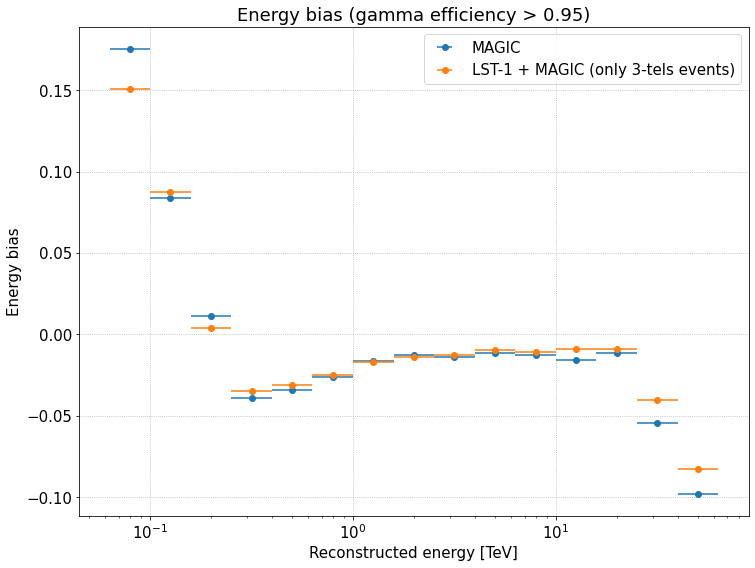

In [28]:
plt.figure()
plt.title(f'Energy bias (gamma efficiency > {gamma_eff})')
plt.xlabel('Reconstructed energy [TeV]')
plt.ylabel('Energy bias')
plt.semilogx()

plt.errorbar(
    ebins_mean, ebias_magic,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    fmt='o', label='MAGIC',
)

plt.errorbar(
    ebins_mean, ebias_mlst,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    fmt='o', label='LST-1 + MAGIC (only 3-tels events)',
)

plt.grid()
plt.legend()
plt.show()

# Check the reconstructed direction

### Theta2 distribution:

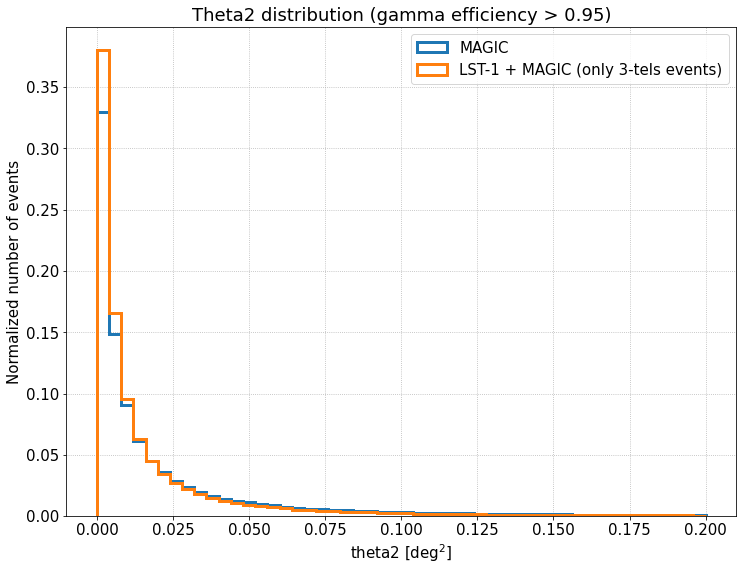

In [29]:
# === Settings ===
bins_t2 = np.linspace(0, 0.2, 51)
yscale = 'linear'

# === Main ===
plt.figure()
plt.title(f'Theta2 distribution (gamma efficiency > {gamma_eff})')
plt.xlabel('theta2 [deg$^2$]')
plt.ylabel('Normalized number of events')
plt.yscale(yscale)

plt.hist(
    dl2_magic['theta2'][mask_gh_magic].to_numpy(), bins=bins_t2, 
    weights=np.repeat(1/len(dl2_magic[mask_gh_magic]), len(dl2_magic[mask_gh_magic])),
    label='MAGIC', histtype='step', linewidth=3,
)

plt.hist(
    dl2_mlst['theta2'][mask_gh_mlst].to_numpy(), bins=bins_t2,
    weights=np.repeat(1/len(dl2_mlst[mask_gh_mlst]), len(dl2_mlst[mask_gh_mlst])),
    label='LST-1 + MAGIC (only 3-tels events)', histtype='step', linewidth=3,
)

plt.grid()
plt.legend()
plt.show()

### Theta2 distribution in each energy bin:

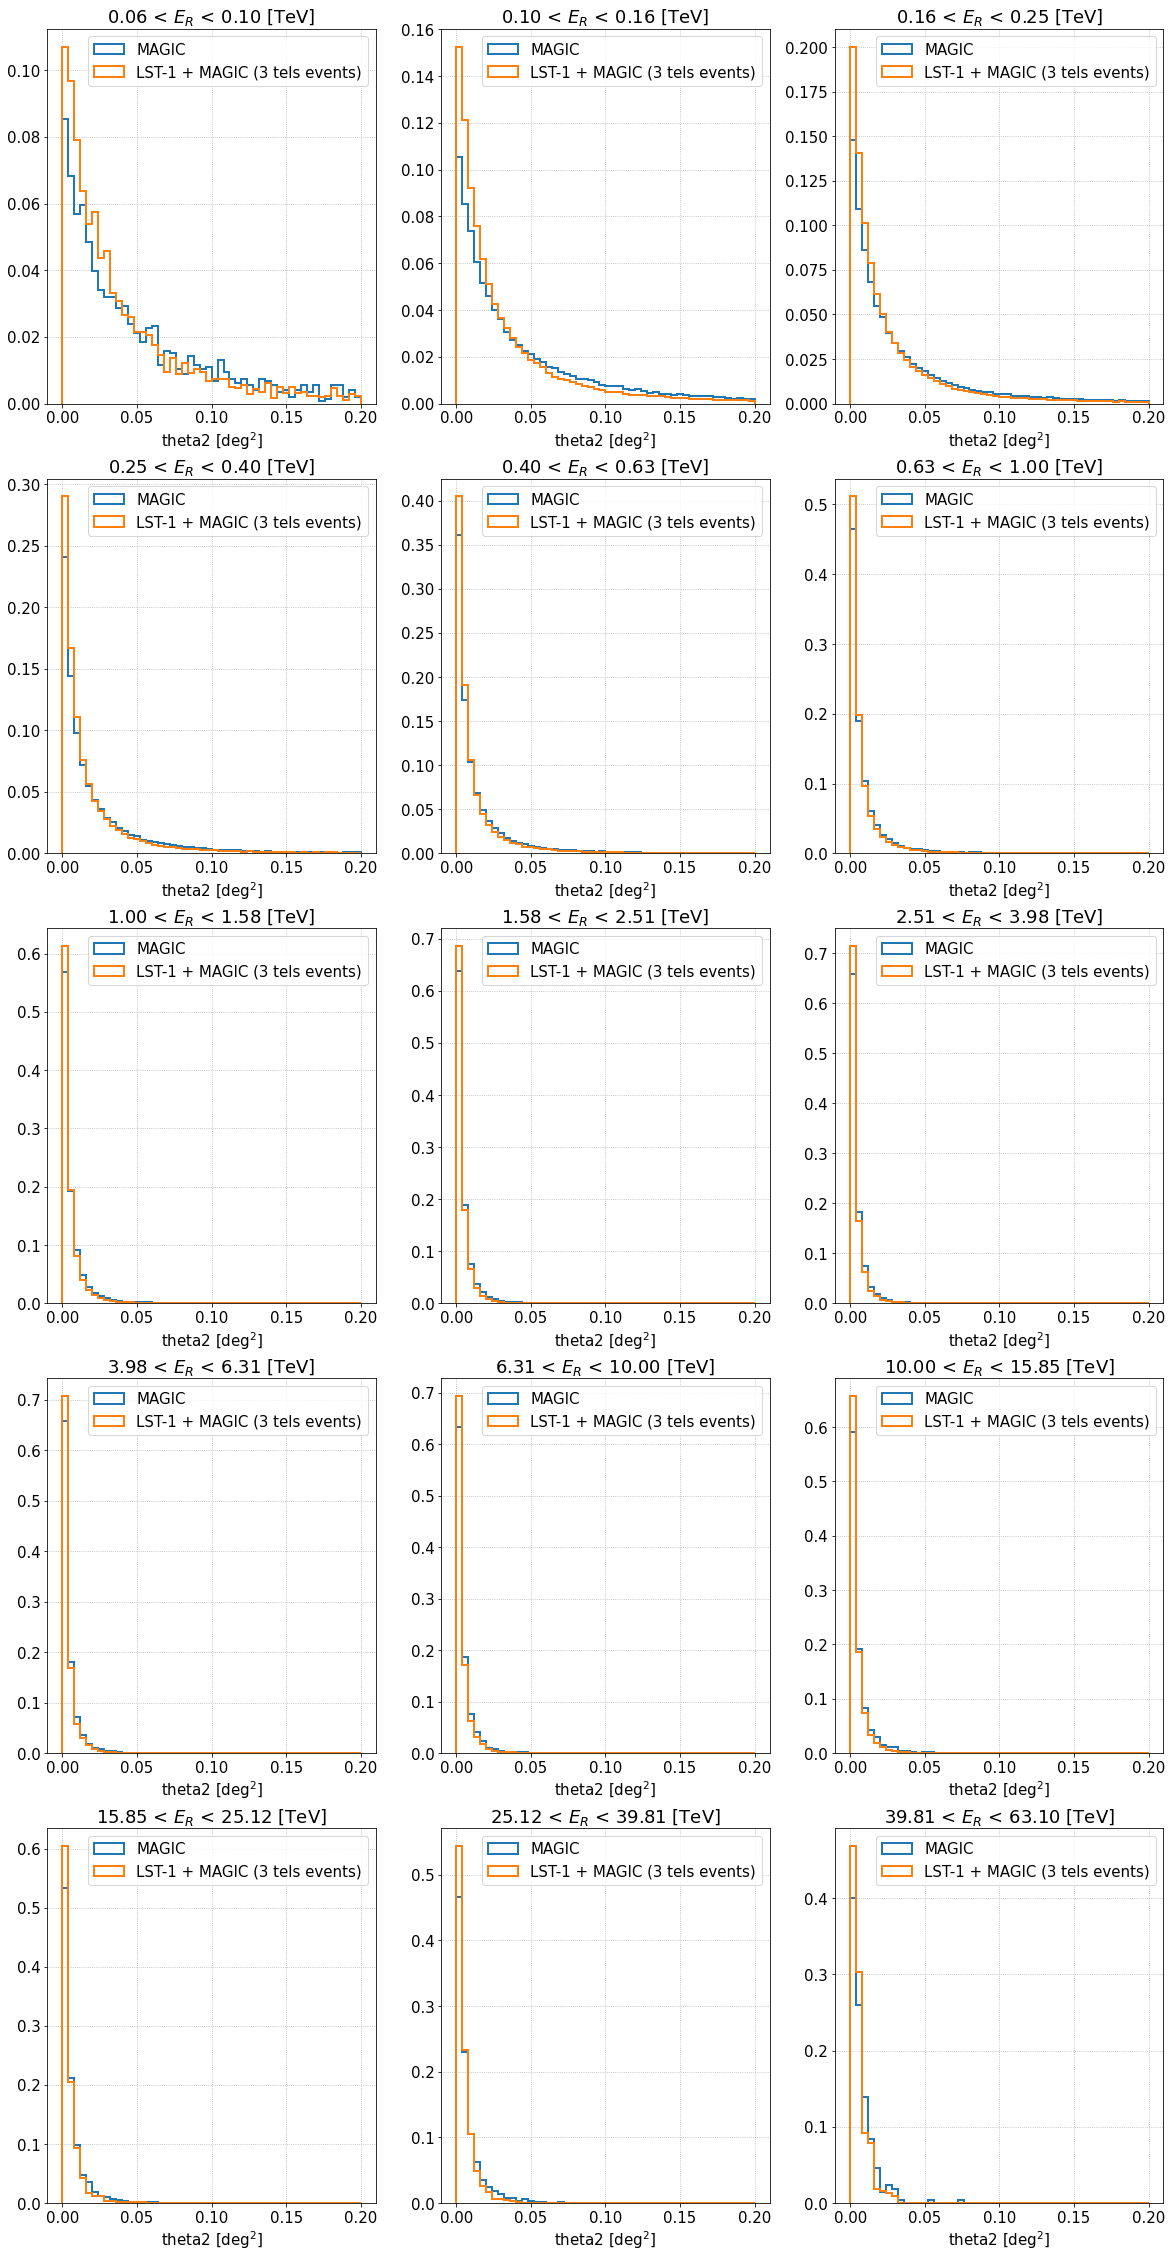

In [30]:
# === Settings ===
bins_eng = np.logspace(-2, 2, 21)[4:-1]
bins_t2 = np.linspace(0, 0.2, 51)

figsize = (20, 40)
yscale = 'linear'

# === Main ===
plt.figure(figsize=figsize)

grid = (int(np.ceil(len(bins_eng[:-1])/3)), 3)
locs = list(itertools.product(range(grid[0]), range(grid[1])))

for i_bin, (eng_lolim, eng_uplim) in enumerate(zip(bins_eng[:-1], bins_eng[1:])):
    
    event_cuts = f'(reco_energy > {eng_lolim}) & (reco_energy < {eng_uplim})'
    
    df_magic = dl2_magic[mask_gh_magic].query(event_cuts)
    df_mlst = dl2_mlst[mask_gh_mlst].query(event_cuts)
    
    plt.subplot2grid(grid, locs[i_bin])
    plt.title(rf'{eng_lolim:.2f} < $E_R$ < {eng_uplim:.2f} [TeV]')
    plt.xlabel('theta2 [deg$^2$]')
    plt.yscale(yscale)

    if len(df_magic) > 0:
        plt.hist(
            df_magic['theta2'].to_numpy(), bins=bins_t2,
            weights=np.repeat(1/len(df_magic), len(df_magic)),
            label='MAGIC', histtype='step', linewidth=2,
        )

    if len(df_mlst) > 0:
        plt.hist(
            df_mlst['theta2'].to_numpy(), bins=bins_t2,
            weights=np.repeat(1/len(df_mlst), len(df_mlst)),
            label='LST-1 + MAGIC (3 tels events)', 
            histtype='step', linewidth=2,
        )

    plt.grid()
    plt.legend(loc='upper right')
    
plt.show()

# Check the angular resolution

In [31]:
ebins, angres_magic = angular_resolution_per_energy(
    reco_alt=dl2_magic['reco_alt'][mask_gh_magic].to_numpy(),
    reco_az=dl2_magic['reco_az'][mask_gh_magic].to_numpy(),
    true_alt=dl2_magic['true_alt'][mask_gh_magic].to_numpy(),
    true_az=dl2_magic['true_az'][mask_gh_magic].to_numpy(),
    energy=dl2_magic['reco_energy'][mask_gh_magic].to_numpy(),
)

_, angres_mlst = angular_resolution_per_energy(
    reco_alt=dl2_mlst['reco_alt'][mask_gh_mlst].to_numpy(),
    reco_az=dl2_mlst['reco_az'][mask_gh_mlst].to_numpy(),
    true_alt=dl2_mlst['true_alt'][mask_gh_mlst].to_numpy(),
    true_az=dl2_mlst['true_az'][mask_gh_mlst].to_numpy(),
    energy=dl2_mlst['reco_energy'][mask_gh_mlst].to_numpy(),
)

# Mask the resolution = 0:
mask = (angres_magic[:, 0] > 0)

angres_magic = angres_magic[mask]
angres_mlst = angres_mlst[mask]

ebins_lo = ebins[:-1][mask]
ebins_hi = ebins[1:][mask]
ebins_mean = logbin_mean(ebins)[mask]

In [32]:
angres_mlst

array([[0.28091175, 0.27273925, 0.28800231],
       [0.23828619, 0.23663703, 0.23989406],
       [0.20665486, 0.20586852, 0.20750116],
       [0.16704421, 0.16619632, 0.16795704],
       [0.12961216, 0.12902895, 0.13032824],
       [0.10434697, 0.10370704, 0.10488991],
       [0.08640067, 0.08583721, 0.08698471],
       [0.07619263, 0.07563795, 0.07672375],
       [0.07282756, 0.07210098, 0.07346029],
       [0.0727513 , 0.07198964, 0.07363539],
       [0.07505218, 0.07399071, 0.07622156],
       [0.0791287 , 0.07793865, 0.08015499],
       [0.08495113, 0.08337538, 0.0867373 ],
       [0.0917613 , 0.0894125 , 0.09406499],
       [0.09745152, 0.09192493, 0.10085328]])

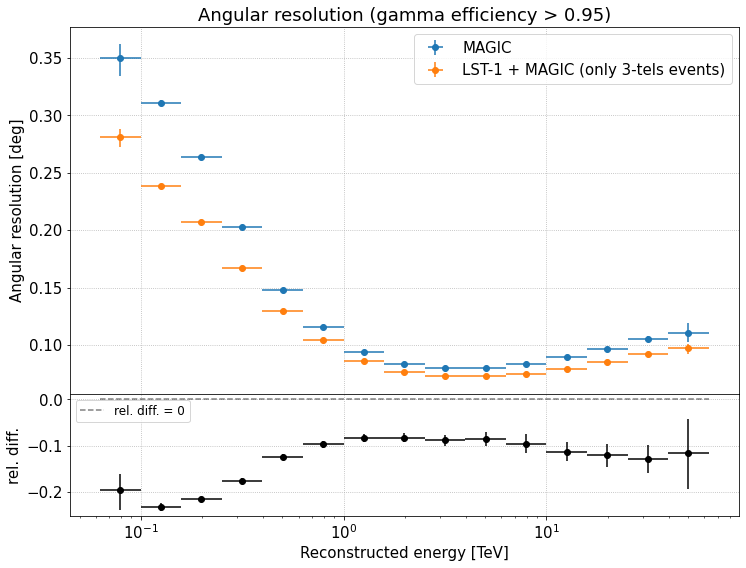

In [34]:
plt.figure()
gs = gridspec.GridSpec(4, 1)

# Plot the Angular resolutions:
ax1 = plt.subplot(gs[:3])
ax1.set_title(f'Angular resolution (gamma efficiency > {gamma_eff})')
ax1.set_ylabel('Angular resolution [deg]')
ax1.semilogx()

ax1.errorbar(
    x=ebins_mean, y=angres_magic[:, 0],
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[angres_magic[:, 0] - angres_magic[:, 1], angres_magic[:, 2] - angres_magic[:, 0]],
    label='MAGIC', fmt='o', 
)

ax1.errorbar(
    x=ebins_mean, y=angres_mlst[:, 0],
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[angres_mlst[:, 0] - angres_mlst[:, 1], angres_mlst[:, 2] - angres_mlst[:, 0]],
    label='LST-1 + MAGIC (only 3-tels events)', fmt='o', 
)

ax1.legend()
ax1.grid()

plt.setp(ax1.get_xticklabels(), visible=False)

# Plot the relative difference: 
ax2 = plt.subplot(gs[3], sharex=ax1)
ax2.set_xlabel('Reconstructed energy [TeV]')
ax2.set_ylabel('rel. diff.')
ax2.semilogx()

rel_diff = (angres_mlst[:, 0] - angres_magic[:, 0]) / angres_magic[:, 0]

yerr_1 = calc_reldiff_err(
    x=angres_mlst[:, 0], y=angres_magic[:, 0], 
    xerr=angres_mlst[:, 0] - angres_mlst[:, 1], 
    yerr=angres_magic[:, 0] - angres_magic[:, 1],
)

yerr_2 = calc_reldiff_err(
    x=angres_mlst[:, 0], y=angres_magic[:, 0], 
    xerr=angres_mlst[:, 2] - angres_mlst[:, 0], 
    yerr=angres_magic[:, 2] - angres_magic[:, 0],
)

ax2.errorbar(
    x=ebins_mean, y=rel_diff,
    xerr=[ebins_mean - ebins_lo, ebins_hi - ebins_mean],
    yerr=[yerr_1, yerr_2], fmt='o', color='black',
)

ax2.plot(
    (ebins_lo[0], ebins_hi[-1]), (0, 0),
    linestyle='--', color='black', alpha=0.5, label='rel. diff. = 0',
)

ax2.grid()
ax2.legend(loc='upper left', fontsize=12)

plt.subplots_adjust(hspace=.0)
plt.show()